# Introduction to Audio Data

Sound waves are continuous signals. We need to discretize it, ie: convert it into a finite digital representation.

`.wav`, `.flac`, `.mp3` are different file formats that do this process in different ways.

![](https://huggingface.co/datasets/huggingface-course/audio-course-images/resolve/main/Signal_Sampling.png)

**Sampling Rate**: Number of samples taken in one second (Hz)

When working with audio data, we must ensure that the sampling rate is consistent across train and test sets. **Resampling** to ensure this may or may not be required in the pre-processing step.

**Amptitude**: Sound pressure level (dB)
**bit depth**: Precision level approximating the continuous wave

For example, 16-bit depth means the continuous values are quantized into 0-65,535 steps. In machine learning, we typically use 32-bit audio which stores samples as floating-point values instead, which lie within [-1.0,1.0].

### As A Waveform

x - time (s)
y = sample values, amptitude

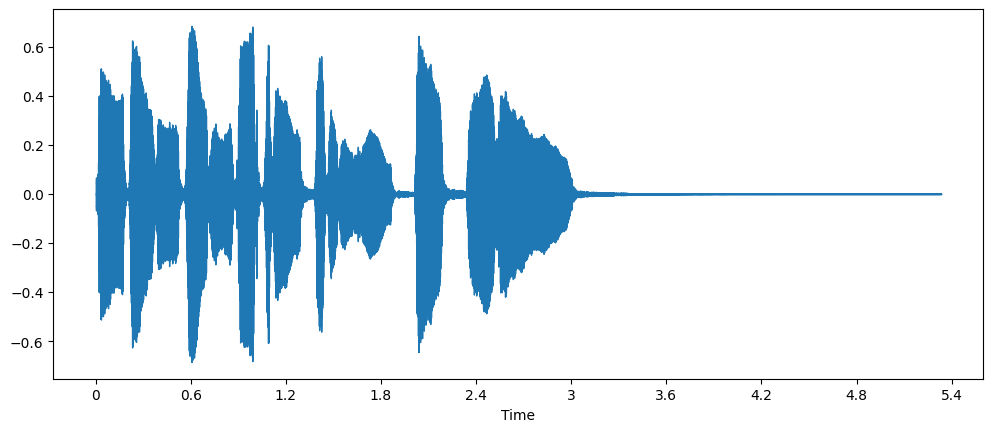

In [7]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display

x, sr = librosa.load(librosa.ex("trumpet"))
plt.figure().set_figwidth(12)
librosa.display.waveshow(x, sr=sr)

### As a Frequency Spectrum

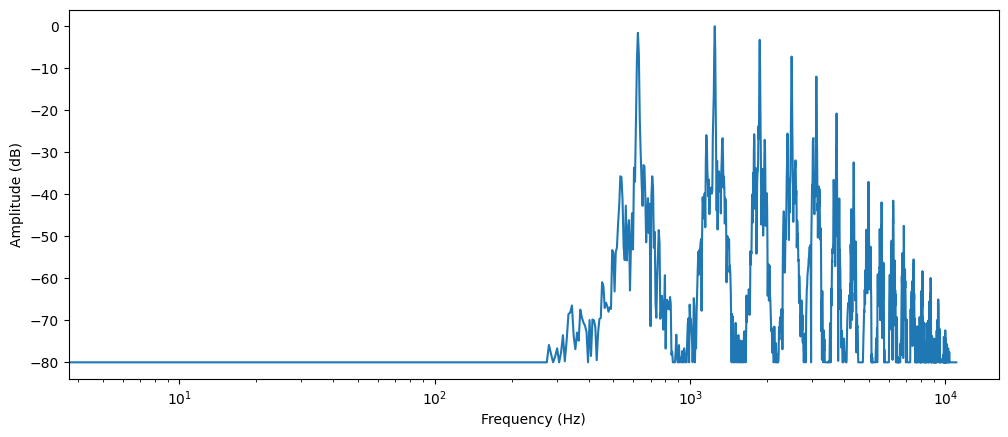

In [2]:
import numpy as np

dft_input = x[:4096] # equivalent to the first note

# calculate DFT
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# get amptitude spectrum in dBs
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sr, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

### As a Spectrogram

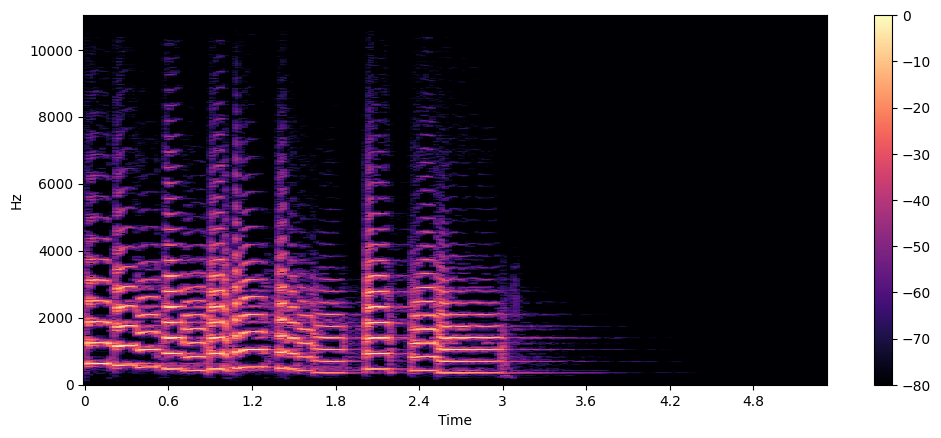

In [6]:
D = librosa.stft(x)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

Spectograms are common inputs to ML models (vision) as they encode 3 forms on data in a single plot -> amptitude, time, frequency

### As a Mel Spectrogram

Distort's the Y-axis to capture the non-linearity of human hearing. ie: more sensitive to changes in lower frequencies than higher frequencies AND sensitivity is logarithmically+inversely related to frequency. 


> Note: This is a lossy operation as it involves **filtering** the signal. Cannot convert back to waveform!

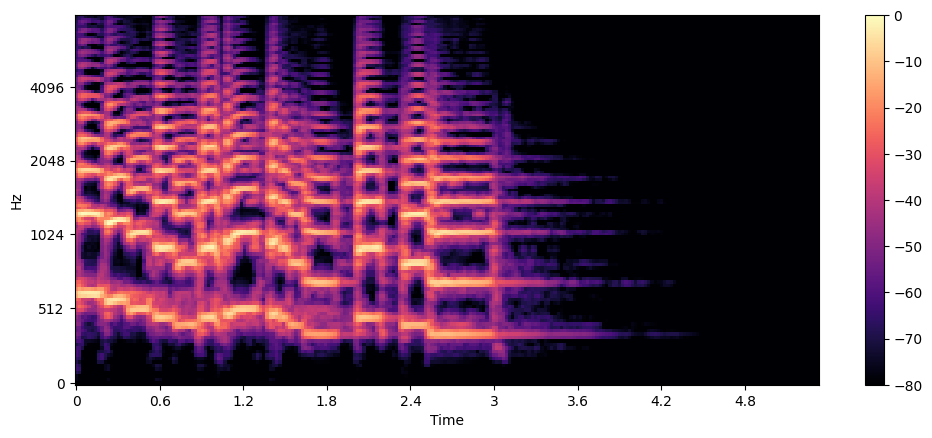

In [11]:
S = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sr, fmax=8000)
plt.colorbar()

In [12]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds

/home/hewliyang/courses/audio-processing/.venv/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating train split: 654 examples [00:00, 17761.20 examples/s]


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [13]:
example = minds[0]; example

{'path': '/home/hewliyang/.cache/huggingface/datasets/downloads/extracted/31eb337cf7413e6843200f4b3ac00e35fccb790b3c71bae50cc288ad90edb58d/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/home/hewliyang/.cache/huggingface/datasets/downloads/extracted/31eb337cf7413e6843200f4b3ac00e35fccb790b3c71bae50cc288ad90edb58d/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [15]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

In [17]:
minds = minds.remove_columns(["lang_id", "english_transcription"])
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [26]:
def generate_audio():
  example = minds.shuffle()[0]
  audio = example["audio"]
  return (
    audio["array"],
    audio["sampling_rate"],
  ), id2label(example["intent_class"])

generate_audio()

((array([0.        , 0.        , 0.        , ..., 0.00048828, 0.00073242,
         0.00073242]),
  8000),
 'business_loan')

In [29]:
for _ in range(4):
  (x, sr), label = generate_audio()
  print("Label: ", label)
  display(Audio(x, rate=sr))

Label:  joint_account


Label:  balance


Label:  freeze


Label:  high_value_payment
